In [4]:
from __future__ import print_function, division
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
seed = 417
%matplotlib inline

ImportError: No module named gym

## Convolutional autoencoder for feature engineering

In [2]:
from keras import backend as K
K.set_image_dim_ordering('th')

Using Theano backend.
Using gpu device 0: GeForce GT 650M (CNMeM is disabled, cuDNN not available)


### Let's collect some samples

In [3]:
max_observations = 2000
observations = []
render = False
count = 0

env_name = 'Skiing-v0'
env = gym.make(env_name)

while True:
    if len(observations) >= max_observations: break
    s = env.reset()
    if count % 10 == 0:
        observations.append(s)
    count += 1
    done = False
    
    while not done:
        if render: env.render()
        if len(observations) >= max_observations: break
        
        a = env.action_space.sample()
        s, r, done, _ = env.step(a)
        if count % 10 == 0:
            observations.append(s)
        count += 1
        
env.close()

INFO:gym.envs.registration:Making new env: Skiing-v0
[2017-01-19 01:27:09,579] Making new env: Skiing-v0


### Some preprocessing

In [4]:
x_train = np.array(observations)
x_train = np.reshape(x_train, tuple([len(x_train)] + list(np.roll(x_train.shape[1:], 1))))
x_train = np.concatenate((x_train, np.zeros((x_train.shape[0], 3, 6, x_train.shape[3]), dtype='uint8')), axis=2)
x_train = x_train.astype('float16') / 255

### Architecture

In [5]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Model
border_mode = 'same'

input_img = Input(shape=x_train.shape[1:])

x = Convolution2D(16, 8, activation='relu', border_mode=border_mode)(input_img)
# x = MaxPooling2D((2, 2), border_mode=border_mode)(x)
x = Convolution2D(32, 4, 4, activation='relu', border_mode=border_mode)(x)
# x = MaxPooling2D((2, 2), border_mode=border_mode)(x)
# x = Convolution2D(16, 3, 3, activation='relu', border_mode=border_mode)(x)
# x = MaxPooling2D((2, 2), border_mode=border_mode)(x)
# x = Convolution2D(8, 3, 3, activation='relu', border_mode=border_mode)(x)
flattened = Reshape((x.shape[0], -1))(x)
encoded = Dense(256, activation='relu')(flattened)

# at this point the representation is (8, 4, 4) i.e. 128-dimensional

unflattened = Reshape((x.shape[0], ))(encoded)
x = Convolution2D(8, 3, 3, activation='relu', border_mode=border_mode)(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, 3, 3, activation='relu', border_mode=border_mode)(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, 3, 3, activation='relu', border_mode=border_mode)(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, 3, 3, activation='relu', border_mode=border_mode)(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(3, 3, 3, activation='relu', border_mode=border_mode)(x)

encoder = Model(input_img, encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

ImportError: No module named keras.layers

In [6]:
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 256, 160)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 256, 160)  448         input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 128, 80)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 128, 80)   2320        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

### Training

In [7]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(float(logs.get('loss')))
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))


In [8]:
history = LossHistory()
autoencoder.fit(x_train, x_train,
                nb_epoch=4,
                batch_size=32,
                shuffle=True,
                callbacks=[history])

Epoch 1/4
2000/2000 [==============================] - 147s - loss: 0.2762   
Epoch 2/4
2000/2000 [==============================] - 151s - loss: 0.1312   
Epoch 3/4
2000/2000 [==============================] - 152s - loss: 0.1042   
Epoch 4/4
2000/2000 [==============================] - 151s - loss: 0.0861   


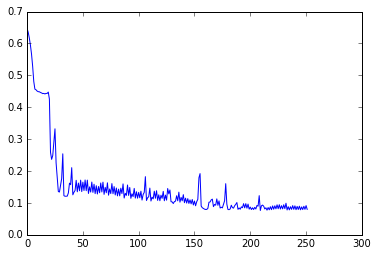

In [9]:
plt.plot(history.losses)
plt.show()

## Linear action-value function approximation for control

### Since we can obtain features for different states, we will have different feature vectors for different actions

In [75]:
class ActionValueFunctionApproximator:
    def __init__(self, nA, dim, alpha=0.01):
        self.w = np.random.rand(nA, dim)
        self.alpha = alpha
        
    def update(self, experience):
        all_actions = np.array(map(lambda x: x[0], experience))
        all_features = np.array(map(lambda x: x[1], experience))
        G = np.cumsum(map(lambda x: x[2], experience)[::-1])[::-1]
        Q = self.predict(all_features.T)
        Q = Q[all_actions, range(len(experience))]
        grads = (G - Q)[:, np.newaxis] * all_features
        
        for action in range(self.w.shape[0]):
            self.w[action] += self.alpha * np.mean(grads[all_actions == action], axis=0)
    
    def predict(self, features):
        return np.dot(self.w, features)

In [76]:
dim = np.prod(encoder.layers[-1].output_shape[1:])
avf = ActionValueFunctionApproximator(env.action_space.n, dim, alpha=0.0001)

In [81]:
eps = 0.9
render = True
env_name = 'Skiing-v0'
env = gym.make(env_name)
#np.random.seed(seed)

for episode in range(1):
    s = env.reset()
    t = 0
    done = False
    experience = []
    
    while not done:
        if render: env.render()
    
        s_tmp = s.reshape(tuple([1] + list(np.roll(s.shape, 1))))
        s_tmp = np.concatenate((s_tmp, np.zeros((s_tmp.shape[0], 3, 6, s_tmp.shape[3]), dtype='uint8')), axis=2)
        features = encoder.predict(s_tmp.astype('float16')/255).ravel()
        
        if eps > np.random.rand():
            a = env.action_space.sample()
        else:
            a = np.argmax(avf.predict(features))
        sp, r, done, _ = env.step(a)
        experience.append((a, features, r))
        
        
        s = sp
        t += 1
        
    avf.update(experience)
    eps = eps * 0.9
    
    print('episode {} finished in {} steps'.format(episode, t))

INFO:gym.envs.registration:Making new env: Skiing-v0
[2017-01-18 20:51:39,665] Making new env: Skiing-v0


episode 0 finished in 2012 steps


## Monte-Carlo Policy Gradient (REINFORCE)

In [23]:
discount = 1.0
render = True

In [36]:
class Agent:
    def __init__(self, env, learning_rate):
        self.nA = env.action_space.n
        n_components = 100
        self.lr = learning_rate
        self.feature_memory = []
        res = encoder.predict(x_train)
        n = res.shape[0]
        observation_examples = np.hstack((res.reshape((n, -1)), 
                                          np.array([env.action_space.sample() for _ in range(n)])[:, np.newaxis]))

        self.scaler = StandardScaler()
        
        self.feature_map = FeatureUnion([("rbf1", RBFSampler(n_components=n_components, gamma=1., random_state=1)),
                                         ("rbf01", RBFSampler(n_components=n_components, gamma=0.1, random_state=1)),
                                         ("rbf10", RBFSampler(n_components=n_components, gamma=10, random_state=1))])

        self.feature_map.fit(self.scaler.fit_transform(observation_examples))
        
        self.theta = np.random.rand(3 * n_components)
    
    def act(self, s):
        s_tmp = s.reshape(tuple([1] + list(np.roll(s.shape, 1))))
        s_tmp = np.concatenate((s_tmp, np.zeros((s_tmp.shape[0], 3, 6, s_tmp.shape[3]), dtype='uint8')), axis=2)
        s_tmp = encoder.predict(s_tmp.astype('float16')/255).ravel()
        Phi_s = self.feature_map.transform(self.scaler.transform(
                np.hstack((np.arange(self.nA)[:, np.newaxis], np.repeat(s_tmp[np.newaxis, :], self.nA, axis=0)))))
        
        self.feature_memory.append(Phi_s)
        self.probs = np.exp(np.dot(Phi_s, self.theta))
        return np.random.choice(self.nA, p=self.probs/np.sum(self.probs))
    
    def update(self, memory):
        gamma = 1 # 0.999
        G = np.cumsum(map(lambda x: x[2], memory)[::-1])[::-1]
        
        for t in range(len(memory)):
            self.theta += self.lr * (self.feature_memory[t][memory[t][1]] - \
                                     np.sum(self.probs[:, np.newaxis] * self.feature_memory[t], axis=0)) * G[t]
        
        self.feature_memory = []

In [37]:

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import FeatureUnion

In [38]:
agent = Agent(env, 0.01)

In [39]:
for e in range(20):
    s = env.reset()
    episode = 0
    done = False
    memory = []
    
    while not done:
        if render: env.render()
        a = agent.act(s)
        sp, r, done, _ = env.step(a)
        memory.append((s, a, r, sp))
        s = sp
        episode += 1
    
    print('episode {} finished in {} steps'.format(e, episode))
    
    agent.update(memory)

episode 0 finished in 1313 steps
episode 1 finished in 1765 steps
episode 2 finished in 705 steps
episode 3 finished in 698 steps
episode 4 finished in 703 steps
episode 5 finished in 704 steps


KeyboardInterrupt: 

In [6]:
plt.plot(history.losses)
plt.show()

NameError: name 'plt' is not defined